# Reciprocity and sensitivity kernels for sea level fingerprints

This notebook illustrates the reciprocity relations discussed in the paper by Al-Attar *et al.* (2023)
 of the same name which is soon to be submitted. In particular, this notebook includes code used to generate 
 all the figures included within that paper. Note that all quantities within the calculations have SI units, but the form of these units is not always shown.

## Setting up the codes

First, we load in the necesarry Python modules. The module ```SLmod.py``` contains much of the code needed for the calculations.

In [58]:
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
import RFmod as RF
from numpy import pi as pi

#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

# get values for some physical parameters
b = SL.b
g = SL.g
rhoi = SL.rhoi
rhow = SL.rhow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now we read in the present day distribution of sea level and ice. This is taken from the ice6g model of:

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011176

The values of the fields are interpolated onto a Gauss Legendre grid at the chosen expansion order. Note that for the calculations in this notebook L = 256 or higher is a sensible value. The maximum possible is L = 1024, this being set by the Love numbers that have been pre-calculated and are read in below. The code also works out the ocean function from sea level and ice thickness. Note that the defintion of the ocean function calculation does not account for isolated regions below sea level. As a result, the Caspian sea is regarded as part of the oceans. This could be readily fixed, but the effects are small and are not important for our present purposes.

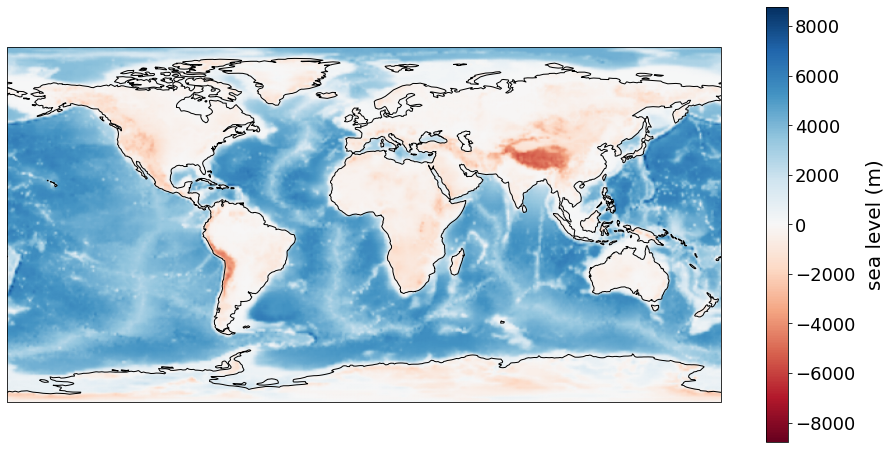

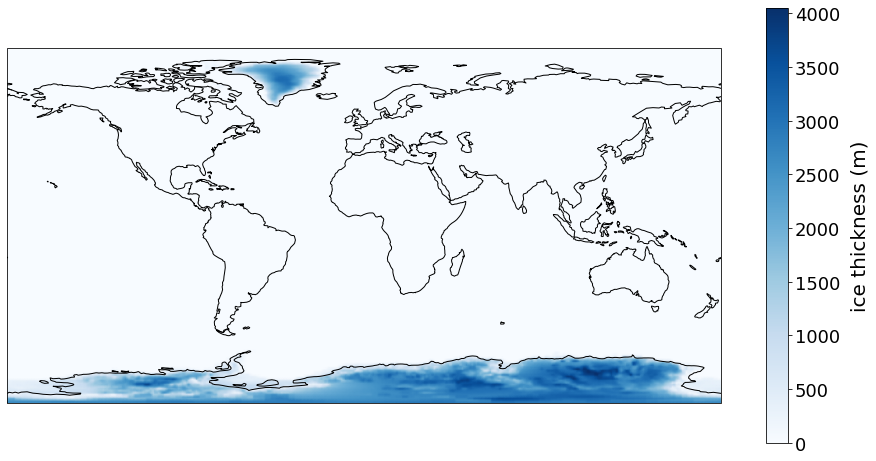

fraction of surface which is ocean =  0.7118907012236343


In [119]:
# set the truncation degree
L=256

# read in the present day sea level and ice thickness
sl0,ice0 = SL.get_sl_ice_data(L)

# plot these fields
SL.plot(sl0,label = 'sea level (m)')
SL.plot(ice0,label = 'ice thickness (m)',clim_pos = True)

# compute the ocean function
C = SL.ocean_function(sl0,ice0)

# work out the ocean area and check the value
A = SL.surface_integral(C)
A_earth = 4*pi*b**2
print('fraction of surface which is ocean = ',A/A_earth)


## Solving the sea level equation to make a synthetic data set


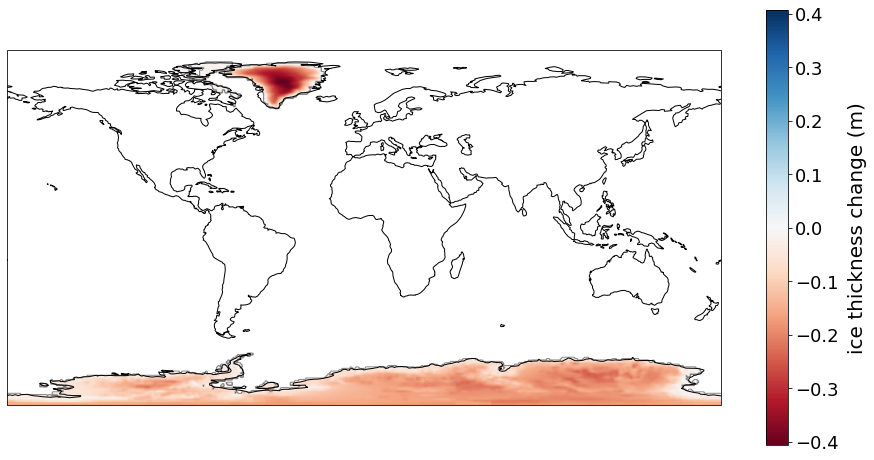

iteration =  1 relative change =  0.04666568576012685
iteration =  2 relative change =  0.005987902241255517
iteration =  3 relative change =  0.0010645011266019134
iteration =  4 relative change =  0.0002138126927703881
iteration =  5 relative change =  4.6831533948908253e-05
iteration =  6 relative change =  1.1025460675915513e-05
iteration =  7 relative change =  2.7690797466416896e-06
iteration =  8 relative change =  7.370992047657761e-07
iteration =  9 relative change =  2.0640217178711006e-07
iteration =  10 relative change =  6.023616714621658e-08
iteration =  11 relative change =  1.814318715366814e-08
iteration =  12 relative change =  5.591365745744659e-09


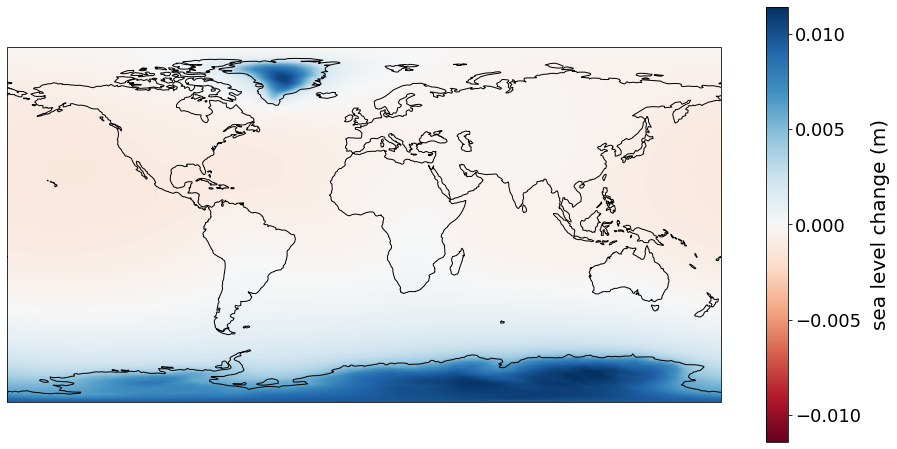

In [146]:
# set to true to use a random ice change model
use_random = False

if(use_random):
    Q = RF.sobolev_covariance(L,s = 2,mu = 1.0,b = b)
    zeta_north = -rhoi*SL.greenland_mask(sl0,ice0,val = 0.)*RF.random_field(Q,b=b)
    zeta_south = -rhoi*SL.antarctica_mask(sl0,ice0,val = 0.)*RF.random_field(Q,b=b)
else:
    zeta_north = -rhoi*SL.zero_southern_hemisphere(ice0)
    zeta_south = -rhoi*SL.zero_northern_hemisphere(ice0)
        

    
# normalise by GMSL contributions
GMSL_north = SL.bathtub(C,zeta_north)
GMSL_south = SL.bathtub(C,zeta_south)
zeta_north /= GMSL_north
zeta_south /= GMSL_south

# set the rate of GMSL change in mm
GMSL = 0.005

# set the northern and southern fractions
f_north = 0.2
f_south = 1.-f_north

# set the combined ice load
zeta = GMSL*(f_north*zeta_north + f_south*zeta_south)

# plot the result with suitable mask
ice_mask = SL.ice_mask(sl0,ice0)
SL.plot(ice_mask*zeta/SL.rhoi,label = r'ice thickness change (m)')

# solve the fingerprint problem
sl,u,phi,om,psi = SL.fingerprint(C,zeta)
ocean_mask = SL.ocean_mask(sl0,ice0)

# plot the result globally
SL.plot(u,clim_scale = 1,label = r'sea level change (m)')



## Sensitivity kernel for sea level at a given location


iteration =  1 relative change =  0.007498751146103141
iteration =  2 relative change =  0.00028322093686329396
iteration =  3 relative change =  3.5835496211931453e-05
iteration =  4 relative change =  7.018183168102175e-06
iteration =  5 relative change =  1.5303368464840141e-06
iteration =  6 relative change =  3.5943469239446664e-07
iteration =  7 relative change =  9.047590290194162e-08
iteration =  8 relative change =  2.4282234772935634e-08
iteration =  9 relative change =  6.950616426875573e-09


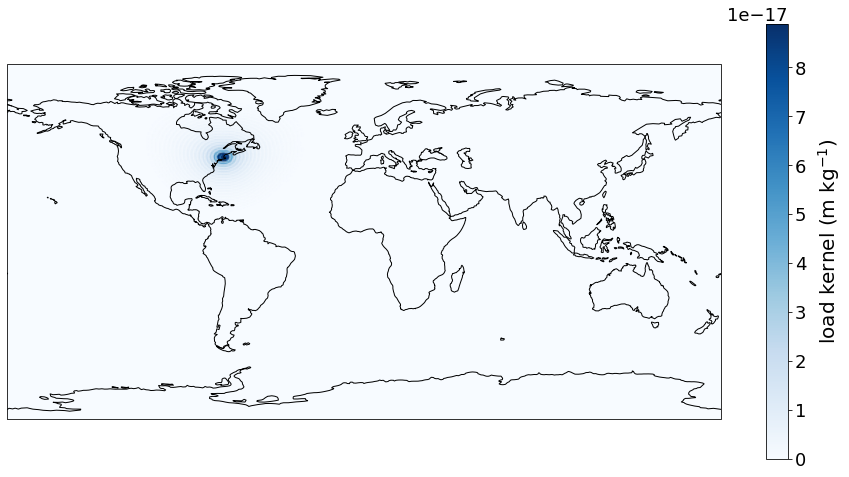

direct sea level value =  0.004618165037407446
left hand side         =  0.00461816503740745
right hand side        =  0.0046181657974589015
relative difference    =  1.6457866821716077e-07


In [121]:
# set the observation point to Boston
lat =  42.3601
lon = -71.0589

# compute the adjoint load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 0.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)',clim_pos = True,clim_scale = 0.1)


# set the value of sea level directly from the field 
sl_direct = SL.point_evaluation(sl,lat,lon)

# evaluate the sea level by integration against the delta load
lhs = SL.surface_integral(zeta_d*sl)

# now get the value by integrating the sensitivity kernel against the direct load
rhs = SL.surface_integral(sl_d*zeta)

# print the values out along with the relative difference
print('direct sea level value = ',sl_direct)
print('left hand side         = ',lhs)
print('right hand side        = ',rhs)
print('relative difference    = ', np.abs((lhs-rhs)/lhs))


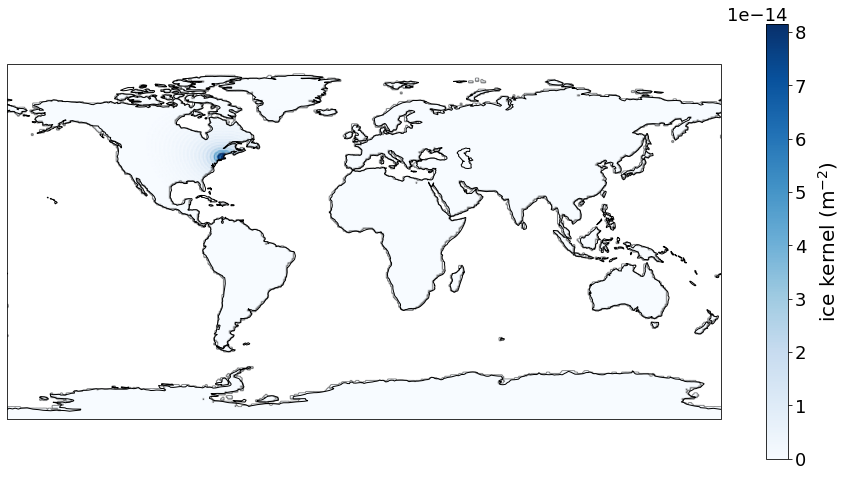

In [122]:
# define and plot the sensitivity kernel with respect to ice thickness
K = SL.rhoi*(1-C)*sl_d
land_mask = SL.land_mask(sl0,ice0)
SL.plot(land_mask*K,label = r'ice kernel (m$^{-2}$)',clim_pos = True,clim_scale = 0.1)

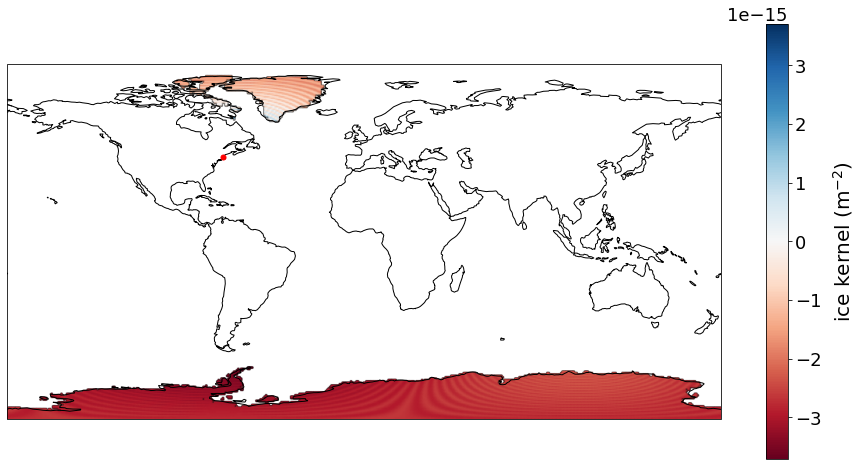

In [123]:
# re-define the kernel such that it is non-zero only where there is grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

iteration =  1 relative change =  0.013156394692021461
iteration =  2 relative change =  0.0005963222416013993
iteration =  3 relative change =  7.416965948410632e-05
iteration =  4 relative change =  1.4487795971984852e-05
iteration =  5 relative change =  3.1562790071333716e-06
iteration =  6 relative change =  7.408105204926895e-07
iteration =  7 relative change =  1.8636060912551847e-07
iteration =  8 relative change =  4.9989090838604156e-08
iteration =  9 relative change =  1.429643908743687e-08
iteration =  10 relative change =  4.3699738039269816e-09


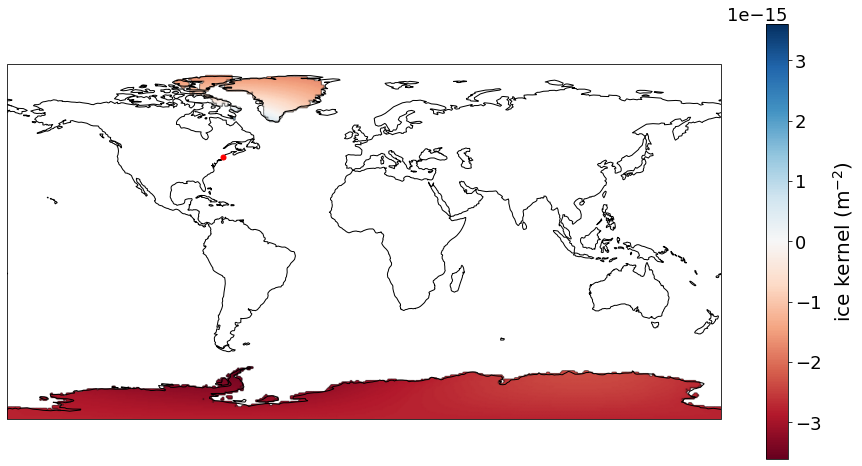

In [124]:
# compute the adjoint load for a SMOOTHED point load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)

# set and plot the kernel projected onto regions of grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])


## Sensitivity kernel for vertical displacement measurement



iteration =  1 relative change =  0.004819684087870366
iteration =  2 relative change =  7.857497597667648e-05
iteration =  3 relative change =  1.858615465066453e-05
iteration =  4 relative change =  4.63476479150165e-06
iteration =  5 relative change =  1.1940995841553627e-06
iteration =  6 relative change =  3.1823565446009557e-07
iteration =  7 relative change =  8.772176959273184e-08
iteration =  8 relative change =  2.4965754329712072e-08
iteration =  9 relative change =  7.31302417249375e-09

direct displacement value =  -0.0003264687967466813
left hand side            =  -0.0003264688388158213
right hand side           =  -0.00032646879674668084
relative difference       =  1.288611206732696e-07

iteration =  1 relative change =  0.0083392067833346
iteration =  2 relative change =  0.0001844582400053322
iteration =  3 relative change =  4.2136973872283094e-05
iteration =  4 relative change =  1.0507506311618043e-05
iteration =  5 relative change =  2.7071374605061e-06
iteration

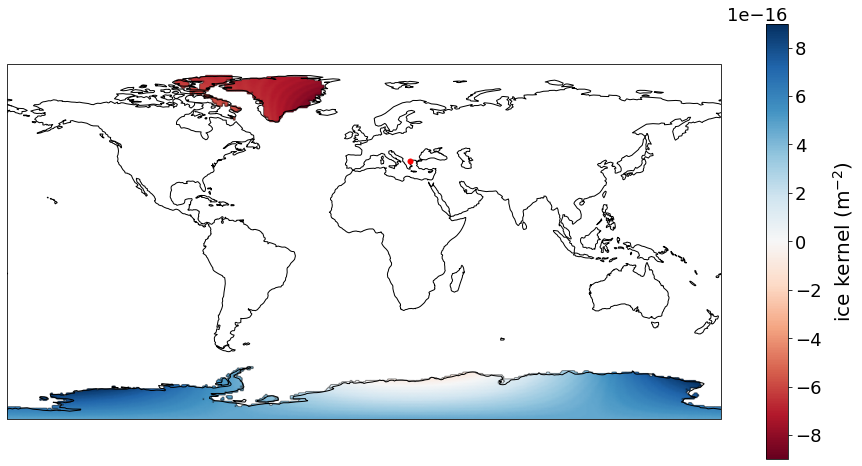

In [125]:
# set the observation point in Thessaloniki
lat = 40.6401
lon = 22.9444
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

iteration =  1 relative change =  0.0022952252277258552
iteration =  2 relative change =  0.00012754502207719642
iteration =  3 relative change =  1.5942569893087654e-05
iteration =  4 relative change =  2.566231408039718e-06
iteration =  5 relative change =  5.101609100031366e-07
iteration =  6 relative change =  1.1299069022395486e-07
iteration =  7 relative change =  2.738257052514206e-08
iteration =  8 relative change =  7.2901577989633e-09

direct displacement value =  0.00017736719981447134
left hand side            =  0.00017736726577710296
right hand side           =  0.00017736719981447096
relative difference       =  3.718985671604476e-07

iteration =  1 relative change =  0.006688727837355189
iteration =  2 relative change =  0.0003159598494569931
iteration =  3 relative change =  3.781040098122708e-05
iteration =  4 relative change =  6.089844266033071e-06
iteration =  5 relative change =  1.16090813183562e-06
iteration =  6 relative change =  2.5602902874659106e-07
iterati

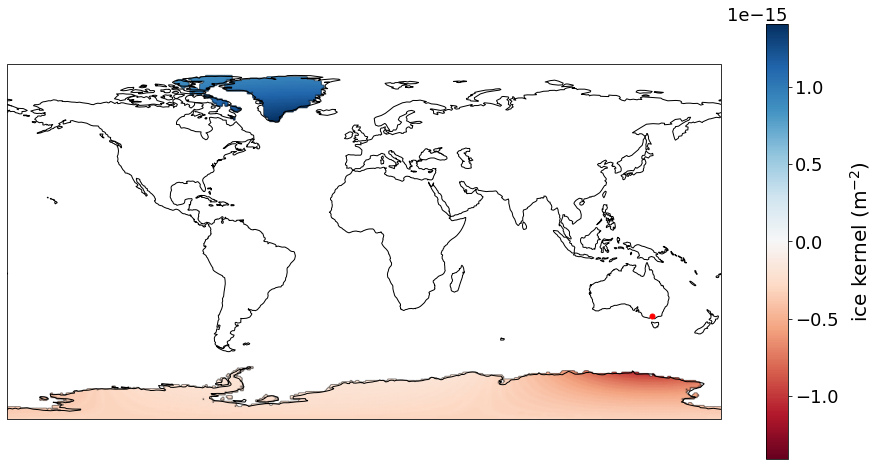

In [56]:
# set the observation point in Melborne
lat = -37.8136
lon = 144.9631
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
cm = np.max(np.abs(K.data))
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon],clim = [-cm,cm])

## Sensitivity kernel for gravitational potential coefficient measurement


iteration =  1 relative change =  0.12121762602298224
iteration =  2 relative change =  0.014917298647378369
iteration =  3 relative change =  0.001967597361395151
iteration =  4 relative change =  0.00032158202062867867
iteration =  5 relative change =  6.016933929220035e-05
iteration =  6 relative change =  1.2780128437142288e-05
iteration =  7 relative change =  3.3029094613691095e-06
iteration =  8 relative change =  9.059333573279534e-07
iteration =  9 relative change =  2.5168873963023765e-07
iteration =  10 relative change =  7.164815619468399e-08
iteration =  11 relative change =  2.0952358478947745e-08
iteration =  12 relative change =  6.282473129281786e-09

direct potential value    =  -0.0014279661807857975
left hand side            =  -0.0014279661245927093
right hand side           =  -0.0014279661807857958
relative difference       =  3.9351834373075755e-08



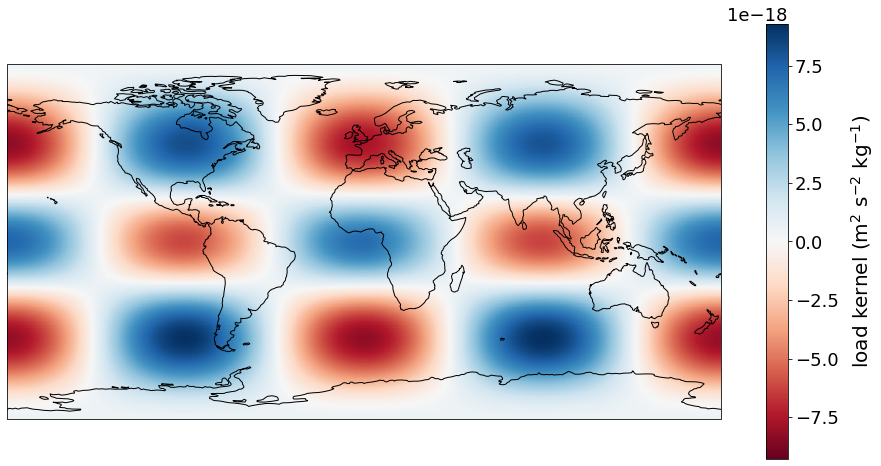

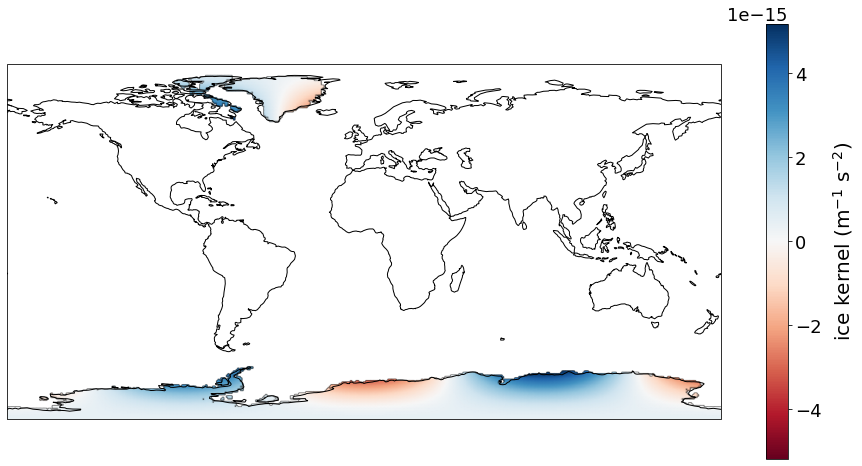

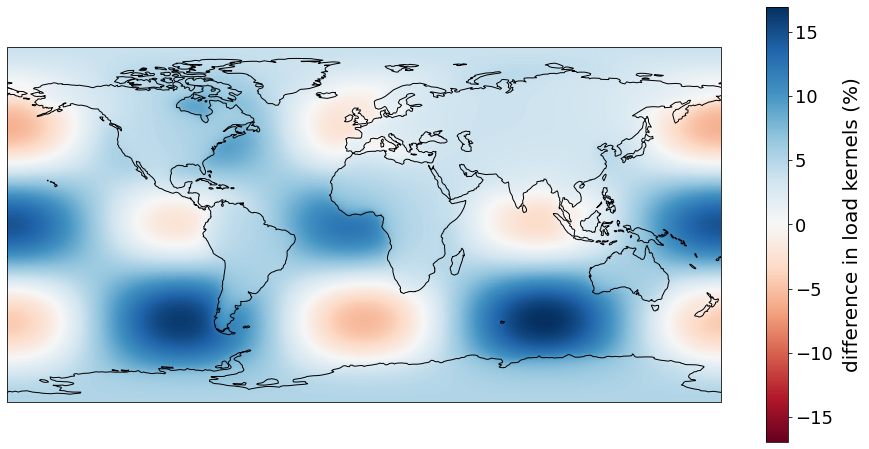

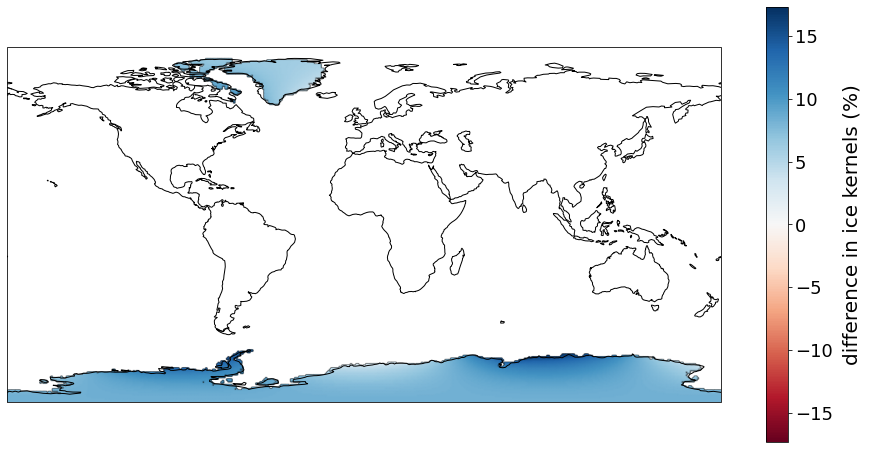

In [126]:
# set the adjoint loads
l = 4
m = 2
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)')


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)')


iteration =  1 relative change =  0.04262237639154837
iteration =  2 relative change =  0.0021600920184978796
iteration =  3 relative change =  0.00014986571474861444
iteration =  4 relative change =  1.6265090103682844e-05
iteration =  5 relative change =  2.6719634499266713e-06
iteration =  6 relative change =  5.255439042432677e-07
iteration =  7 relative change =  1.1600389999075782e-07
iteration =  8 relative change =  2.7395941913949517e-08
iteration =  9 relative change =  6.849698126204816e-09

direct potential value    =  0.0005184131572048069
left hand side            =  0.000518413149099227
right hand side           =  0.000518413157204807
relative difference       =  1.5635367319202843e-08



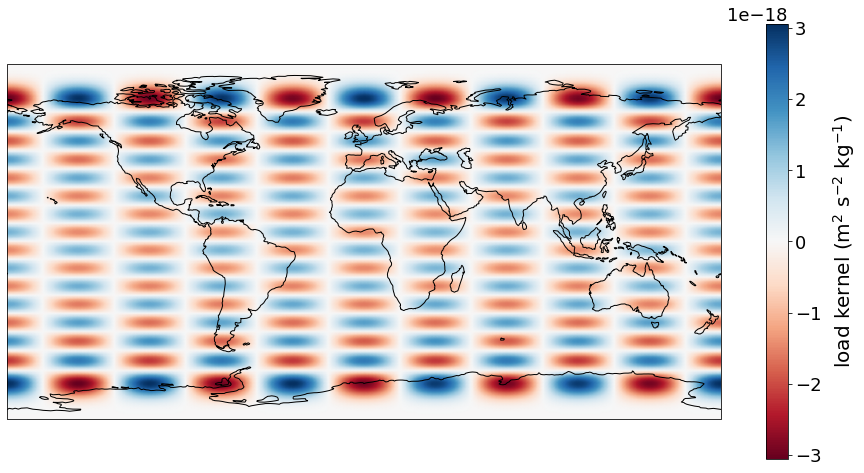

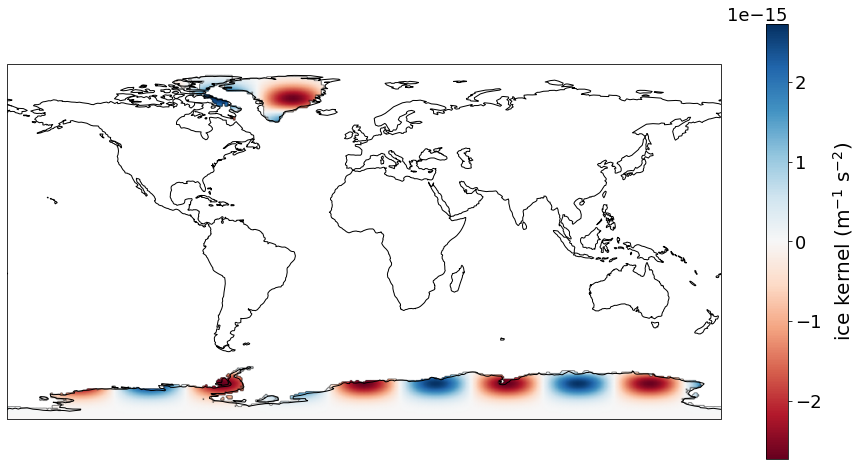

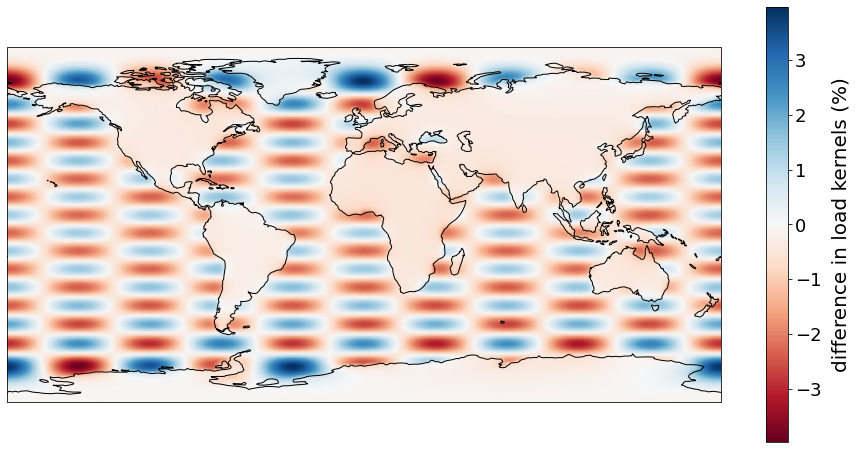

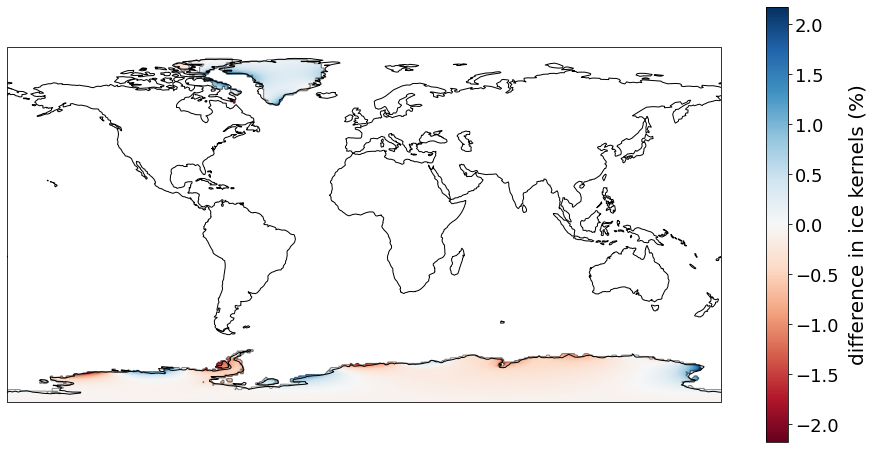

In [127]:
# set the adjoint loads for a higher degree
l = 20
m = 5
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)')


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)')


## Sensitivity kernels for Grace load averages

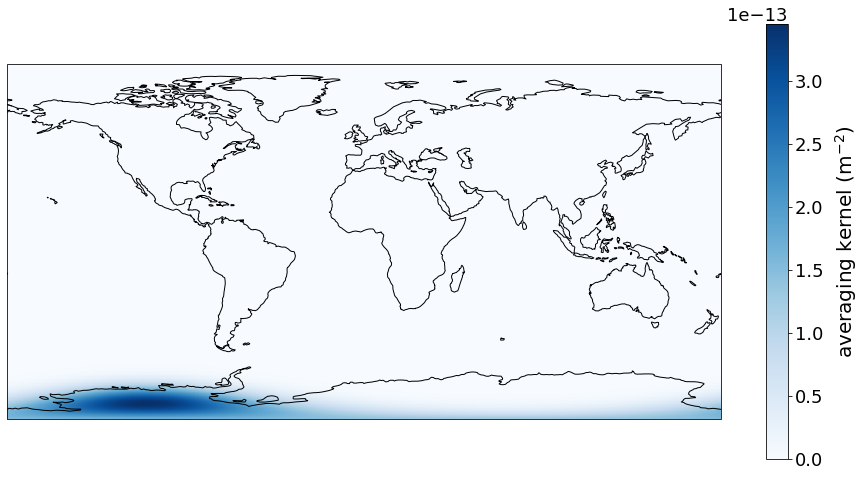

iteration =  1 relative change =  0.019301027473807117
iteration =  2 relative change =  0.0008358429202488157
iteration =  3 relative change =  8.859621680071372e-05
iteration =  4 relative change =  1.815584640875101e-05
iteration =  5 relative change =  3.971452261404151e-06
iteration =  6 relative change =  9.327020665785875e-07
iteration =  7 relative change =  2.3537494911432687e-07
iteration =  8 relative change =  6.34280038133987e-08
iteration =  9 relative change =  1.8040996595569e-08
iteration =  10 relative change =  5.345980400021447e-09

left hand side            =  -63.69495393390598
right hand side           =  -63.69496041187211
relative difference       =  1.0170297223599246e-07



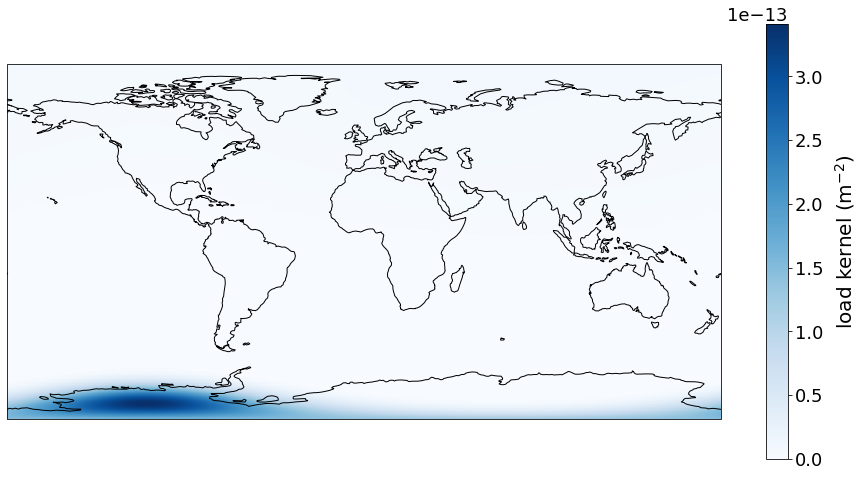

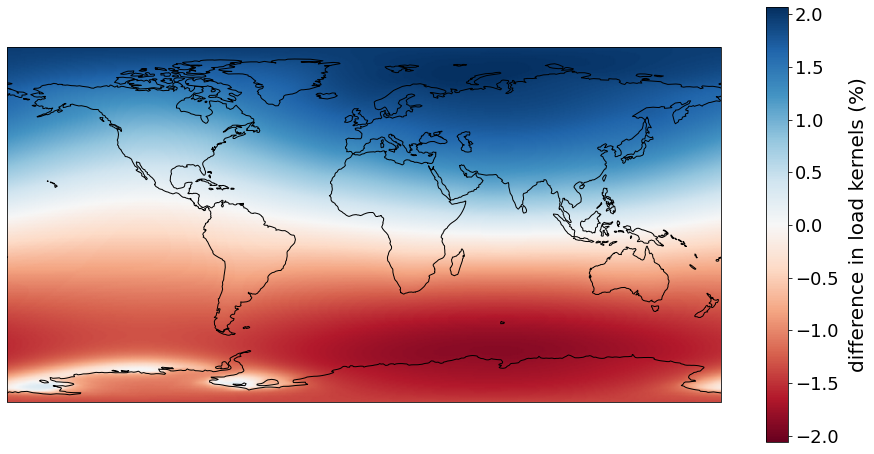

GRACE average of load =  -0.06369496041187207
average of direct load  =  -0.06911042870756512
relative difference with direct load average   =  -7.835963973842701 %


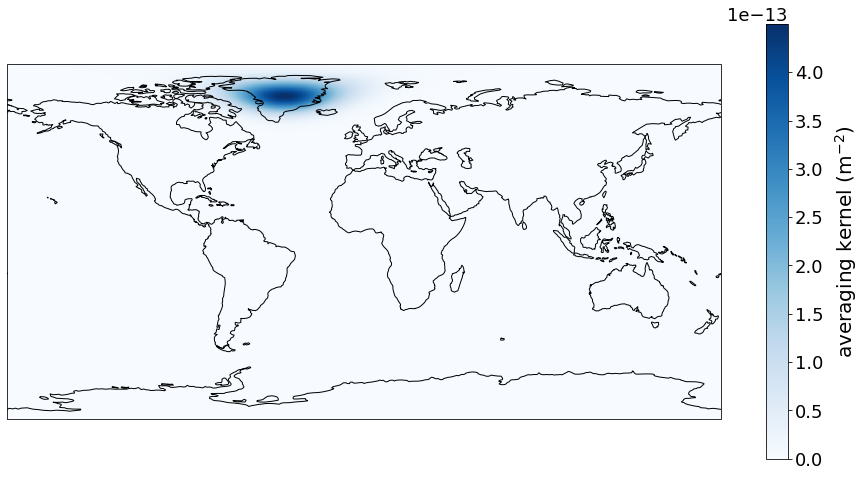

iteration =  1 relative change =  0.021489834141146805
iteration =  2 relative change =  0.001259081594975224
iteration =  3 relative change =  0.000151297382793903
iteration =  4 relative change =  3.6147273086684286e-05
iteration =  5 relative change =  8.984835143576636e-06
iteration =  6 relative change =  2.333354244009024e-06
iteration =  7 relative change =  6.334978750351052e-07
iteration =  8 relative change =  1.7919064797887704e-07
iteration =  9 relative change =  5.2512211268857275e-08
iteration =  10 relative change =  1.5830191649497967e-08
iteration =  11 relative change =  4.87590302558764e-09

left hand side            =  -116.94947153645334
right hand side           =  -116.9494744331801
relative difference       =  2.476904527481905e-08



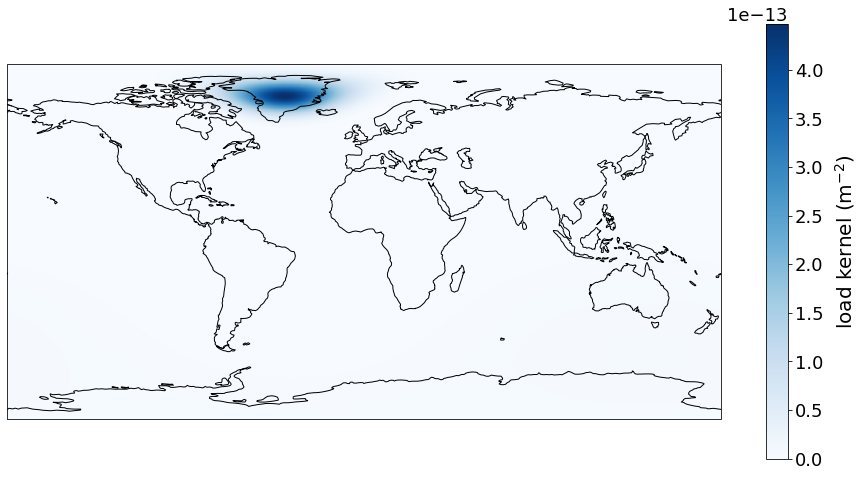

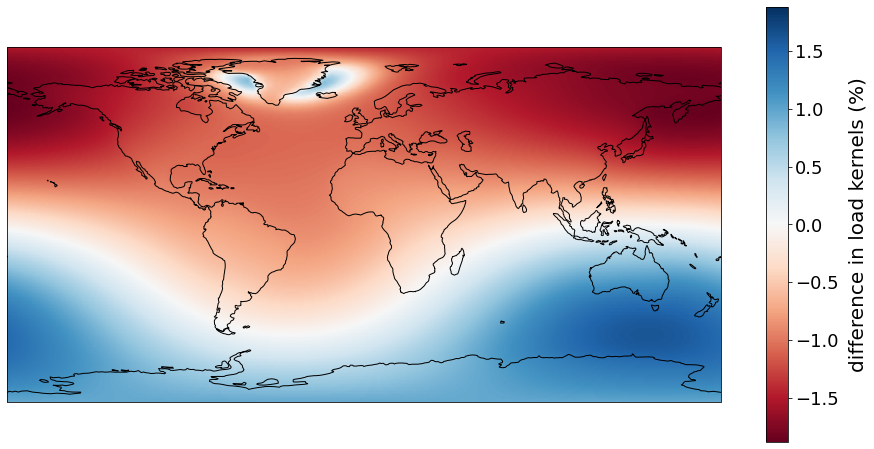

GRACE average of load =  -0.11694947443318002
average of direct load  =  -0.11129318903356454
relative difference with direct load average   =  5.082328441419373 %


In [131]:
# cut out degrees 0 and 1 from averaging function?
cut = False

# truncation degree for GRACE average (LT = 0 means no truncation)
LT = 100


# define the averaging function as in Wahr et al. (1998) targeted at W. Antarctic
w = SL.gaussian_averaging_function(L,r = 800,lat0 = -82.,lon0 = -110.,cut = cut)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)',clim_pos = True)


# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',cmap = "Blues",clim_pos = True)

GRACE_average = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow

# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)',clim_sym = True)

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')


##########################################################
# now do the same thing but for a Greenland average

# define the averaging function as in Wahr et al. (1998) targeted at W. Antarctic
w = SL.gaussian_averaging_function(L,r = 700,lat0 = 73.,lon0 = -40.,cut = cut)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)',clim_pos = True)

# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',clim_pos = True)

GRACE_average      = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow


# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)')

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')



## Case 4: Sensitivity kernels for sea surface height

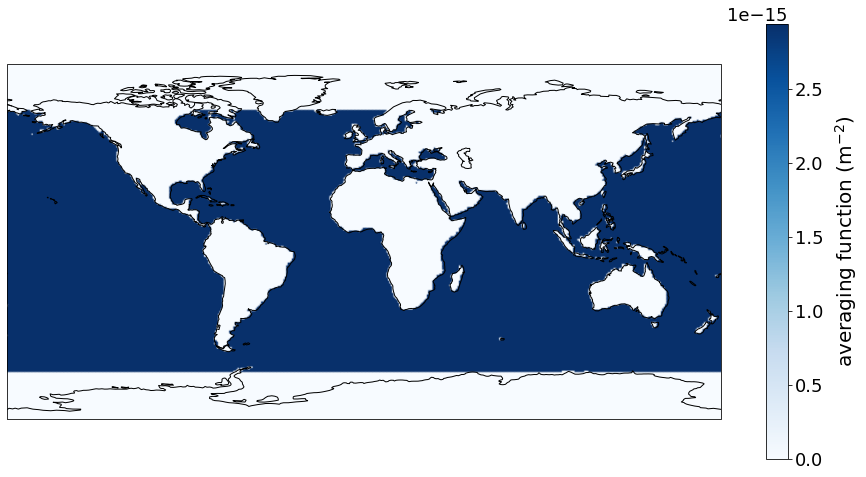

iteration =  1 relative change =  0.009431655356331316
iteration =  2 relative change =  0.0018000596990000027
iteration =  3 relative change =  0.0003989903053465671
iteration =  4 relative change =  8.921379159333109e-05
iteration =  5 relative change =  2.0150644050968456e-05
iteration =  6 relative change =  4.60544617233634e-06
iteration =  7 relative change =  1.0668542844116907e-06
iteration =  8 relative change =  2.5107664481194323e-07
iteration =  9 relative change =  6.02223215737124e-08
iteration =  10 relative change =  1.4776734372843495e-08
iteration =  11 relative change =  3.722634152671196e-09

direct ssh value     =  0.0048974615020405034
left hand side       =  0.004897461458590715
right hand side      =  0.004897461502040504
relative difference  =  8.87190012071984e-09



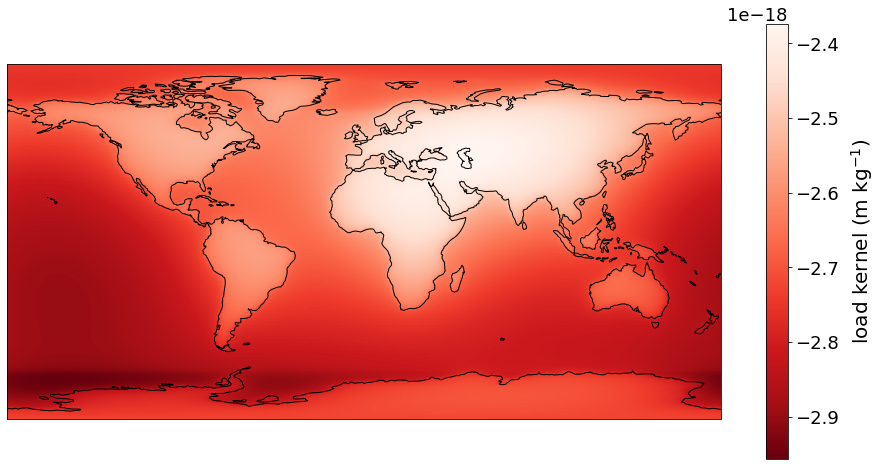

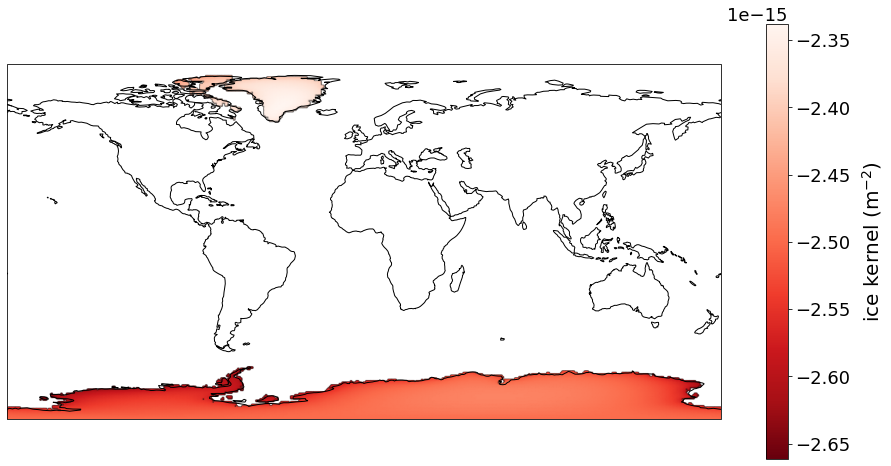

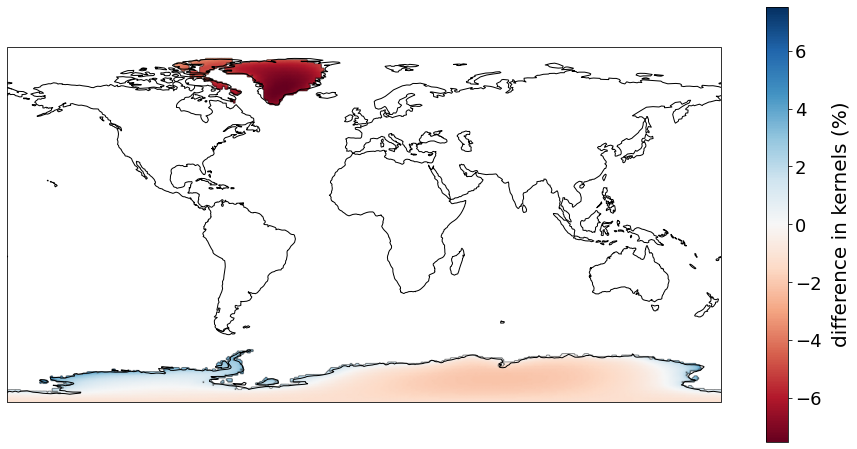

percentage difference from GMSL =  -2.050769959189933 %

iteration =  1 relative change =  0.020810035129174745
iteration =  2 relative change =  0.0025168834371969615
iteration =  3 relative change =  0.0004218633492614692
iteration =  4 relative change =  8.333842199020502e-05
iteration =  5 relative change =  1.8143839733395208e-05
iteration =  6 relative change =  4.260186601385377e-06
iteration =  7 relative change =  1.0734379299108167e-06
iteration =  8 relative change =  2.8867774253614976e-07
iteration =  9 relative change =  8.254289608496889e-08
iteration =  10 relative change =  2.5250184238157035e-08
iteration =  11 relative change =  7.866995103212697e-09

percentage difference from GMSL =  -6.848152552065087 %


In [139]:
# set the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_altimetery_load(sl0,ice0)

SL.plot(zeta_d,label = r'averaging function (m$^{-2}$)',clim_pos = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# form the sea surface height directly
ssh = sl + u + psi/SL.g

# set the observational area and form the average
ssh_direct = SL.surface_integral(ssh*zeta_d)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct ssh value     = ',ssh_direct)
print('left hand side       = ',lhs)
print('right hand side      = ',rhs)
print('relative difference  = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)',clim_sym = False,cmap = "Reds_r")

# plot the kernel wrt I
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',clim_sym = False,cmap = "Reds_r")

Kval = -SL.rhoi/(SL.rhow*A)
Ki = Kval*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(100*ice_mask*(K-Ki)/Kval,label = r'difference in kernels (%)')

# determine the difference between the altimetery estimate the GMSL
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")
print('')



#######################################################################
# do the same again, but now consider a northern hemisphere only source

zeta_2 = GMSL*zeta_north
sl_2,u_2,phi_2,om_2,psi_2 = SL.fingerprint(C,zeta_2)
ssh_2 = sl_2 + u_2 + psi_2/SL.g
ssh_direct = SL.surface_integral(ssh_2*zeta_d)
print('')
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")
